<a href="https://colab.research.google.com/github/niral28/TransformersPuzzles/blob/main/TwoTowerRecommendationMovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

DATA_DIR='data'
# # ! wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/
# ! unzip archive.zip -d data/



In [2]:
def load_user_data(path:str)->pd.DataFrame:
  df_user = pd.read_csv(path, delimiter='|', header=None, names=['userId', 'age', 'gender', 'profession', 'zipcode'])

  # Define the bins and labels for age groups
  bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, float('inf')]
  labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75+']


  # Create a new column 'age_group' by binning the 'age' column
  df_user['age_group'] = pd.cut(df_user['age'], bins=bins, labels=labels, right=False)
  return df_user

In [3]:
df_user = load_user_data(os.path.join(DATA_DIR, 'u.user'))

le_age = LabelEncoder()
le_age.fit(df_user['age_group'])
le_job = LabelEncoder()
le_job.fit(df_user['profession'])
le_gender = LabelEncoder()
le_gender.fit(df_user['gender'])


def encodeFeatures(df_user, le_age, le_job, le_gender):
  df_user['age_group'] = le_age.transform(df_user['age_group'])
  df_user['profession'] = le_job.transform(df_user['profession'])
  df_user['gender'] = le_gender.transform(df_user['gender'])
  df_user.drop(columns=['age', 'zipcode'], inplace=True)

encodeFeatures(df_user, le_age, le_job, le_gender)
df_user.head()

,userId,gender,profession,age_group
0,1,1,19,2
1,2,0,13,9
2,3,1,20,2
3,4,1,19,2
4,5,0,13,4


In [4]:
def load_data(path:str)->pd.DataFrame:
  df_data = pd.read_csv(path, delimiter='\t', header=None, names=['userId', 'itemId', 'rating', 'timestamp'])
  df_data['like'] = df_data['rating'].apply(lambda x: 1 if x>=4 else 0)
  return df_data

In [5]:
def load_item(path:str)->pd.DataFrame:
  df_item = pd.read_csv(path, delimiter='|', header=None, encoding='latin-1')
  df_item.columns = [
    'itemId', 'title', 'releaseDate', 'videoReleaseDate', 'imdbUrl', 'unknown', 'action', 'adventure', 'animation',
    'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror', 'musical', 'mystery', 'romance',
    'sciFi', 'thriller', 'war', 'western'
]
  df_item.drop(columns=['releaseDate', 'videoReleaseDate', 'imdbUrl', 'title'], inplace=True)
  return df_item

In [6]:
df_item = load_item(os.path.join(DATA_DIR, 'u.item'))
num_movies = df_item['itemId'].nunique()
# def generate_negative_samples(ratings_df, num_movies, neg_ratio=4):
#     """
#     Generates negative samples by randomly selecting movies a user hasn't rated.
#     """
#     all_movie_ids = set(range(num_movies))
#     negative_samples = []

#     for user_id, user_data in ratings_df.groupby("userId"):
#         positive_movies = set(user_data["itemId"].values)
#         negative_movies = list(all_movie_ids - positive_movies)
#         sampled_negatives = np.random.choice(negative_movies, size=min(len(positive_movies) * neg_ratio, len(negative_movies)), replace=False)

#         for neg_movie in sampled_negatives:
#             negative_samples.append([user_id, neg_movie, 0])  # '0' for negative label

#     negative_df = pd.DataFrame(negative_samples, columns=["userId", "itemId", "like"])
#     return pd.concat([ratings_df[["userId", "itemId", "like"]], negative_df]).sample(frac=1).reset_index(drop=True)


df_data = load_data(os.path.join(DATA_DIR, 'u.data'))

df_data_train = load_data(os.path.join(DATA_DIR, 'ua.base'))
df_data_test = load_data(os.path.join(DATA_DIR, 'ua.test'))

In [7]:
def get_mergedDF(df_data, df_user, df_item):
  merged_df = df_data.merge(df_user, on='userId').merge(df_item, on='itemId')
  return merged_df

merged_df = get_mergedDF(df_data, df_user, df_item)
merged_df_train = get_mergedDF(df_data_train, df_user, df_item)
merged_df_test = get_mergedDF(df_data_test, df_user, df_item)
merged_df.head()

,userId,itemId,rating,timestamp,like,gender,profession,age_group,unknown,action,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,196,242,3,881250949,0,1,20,7,0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,0,0,6,5,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,0,1,20,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,0,1,19,3,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,0,1,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
num_genres = len(df_item.drop(columns=['itemId']).iloc[0].values)
num_age_groups = df_user['age_group'].nunique()+1
num_professions = df_user['profession'].nunique()+1
num_users = df_user['userId'].max()+1
num_movies = df_item['itemId'].nunique()+1

In [9]:
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import BatchNorm1d
import torch.nn.functional as F

def info_nce_loss(similarity_matrix, temperature=0.07):
    # Positive pairs are on diagonal
    batch_size = similarity_matrix.size(0)
    labels = torch.arange(batch_size, device=similarity_matrix.device)

    # Scale similarities
    similarity_matrix = similarity_matrix / temperature

    # InfoNCE loss: -log(exp(pos_score) / sum(exp(all_scores)))
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss


class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

class MovieTwoTowerModel(nn.Module):
  def __init__(self, num_users, num_movies, num_age_groups, num_professions, num_genres, embedding_dim):
    super(MovieTwoTowerModel, self).__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.num_genres = num_genres
    self.num_age_groups = num_age_groups
    self.num_professions = num_professions
    self.embedding_dim = embedding_dim

    self.user_embedding = nn.Embedding(num_users, embedding_dim)
    self.age_embedding = nn.Embedding(num_age_groups, 4)
    self.profession_embedding = nn.Embedding(num_professions, 4)
    self.gender_embedding = nn.Embedding(2, 2)

    self.user_fc = nn.Sequential(
        nn.Linear(embedding_dim+4+4+2, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),

    )

    self.genre_fc = nn.Linear(num_genres, 16)
    self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
    self.movie_fc = nn.Sequential(
        nn.Linear(embedding_dim+16, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0003, weight_decay=1e-5)
    self.early_stopper = EarlyStopping()
    self.scheduler = ReduceLROnPlateau(self.optimizer, 'min')
    self.temperature = 0.2
    self.train_loss = []
    self.val_loss = []

  def get_early_stopper(self):
    return self.early_stopper

  def get_metrics(self):
    return self.train_loss, self.val_loss

  def forward(self, user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like=None):
    # User Tower
    user_embedding = self.user_embedding(user_input)
    age_embedding = self.age_embedding(age_input)
    profession_embedding = self.profession_embedding(profession_input)
    gender_embedding = self.gender_embedding(gender_input)
    user_feats = torch.cat([user_embedding, age_embedding, profession_embedding, gender_embedding], dim=1)
    # print(user_feats.shape)
    user_feats = self.user_fc(user_feats)
    # print("user", user_feats.shape)

    # Movie Tower
    movie_embedding = self.movie_embedding(movie_input)
    genre_embedding = self.genre_fc(genre_feats)
    movie_feats = torch.cat([movie_embedding, genre_embedding], dim=1)
    # print(movie_feats.shape)
    movie_feats = self.movie_fc(movie_feats)
    # print("movie", movie_feats.shape)
    user_feats = F.normalize(user_feats, p=2, dim=1)
    movie_feats = F.normalize(movie_feats, p=2, dim=1)
    # Compute Similarity Mtarix
    similarity_matrix = torch.matmul(user_feats, movie_feats.transpose(0, 1))
    if like is not None:
      loss = info_nce_loss(similarity_matrix, temperature=self.temperature)
      return loss, similarity_matrix, user_feats, movie_feats
    else:
      return similarity_matrix, user_feats, movie_feats

  def user_tower(self, user_input, age_input, gender_input, profession_input):
    user_embedding = self.user_embedding(user_input)
    age_embedding = self.age_embedding(age_input)
    profession_embedding = self.profession_embedding(profession_input)
    gender_embedding = self.gender_embedding(gender_input)
    user_feats = torch.cat([user_embedding, age_embedding, profession_embedding, gender_embedding], dim=1)
    user_feats = self.user_fc(user_feats)
    user_feats = F.normalize(user_feats, p=2, dim=1)
    return user_feats

  def movie_tower(self, movie_input, genre_input):
    movie_embedding = self.movie_embedding(movie_input)
    genre_embedding = self.genre_fc(genre_input)
    movie_feats = torch.cat([movie_embedding, genre_embedding], dim=1)
    movie_feats = self.movie_fc(movie_feats)
    movie_feats = F.normalize(movie_feats, p=2, dim=1)
    return movie_feats

  def fit(self, epochs, train_dataloader, val_dataloader):
      early_stopper = EarlyStopping(patience=3, delta=10)
      for epoch in range(epochs):
          self.train()
          epoch_loss = 0.0
          for batch in train_dataloader:
              user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like = batch
              loss, _ , _ , _ = self(user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like)
              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()
              epoch_loss += loss.item()
          avg_train_loss = epoch_loss / len(train_dataloader)
          print(f"train step {epoch}: train loss {avg_train_loss:.4f}")
          self.train_loss.append(avg_train_loss)
          self.eval()
          val_loss = 0.0
          for batch in val_dataloader:
              user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like = batch
              loss, _ , _ , _ = self(user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like)
              val_loss += loss.item()
          avg_val_loss = val_loss / len(val_dataloader)
          print(f"val step {epoch}: val loss {avg_val_loss:.4f}")
          self.val_loss.append(avg_val_loss)
          self.scheduler.step(avg_val_loss)
          self.train()
          self.early_stopper(avg_val_loss, model)
          if self.early_stopper.early_stop:
              print("Early stopping")
              break


In [10]:
class MovieDatasetWithFeatures(torch.utils.data.Dataset):
    def __init__(self, ratings_df, device):
        """
        ratings_df: DataFrame containing columns ['userId', 'itemId', 'like', 'age_group', 'gender', 'profession', genre columns]
        device: Device to load tensors on (e.g., 'cuda' or 'cpu')
        """
        self.device = device
        self.ratings_df = ratings_df
        self.genre_df = self.ratings_df.drop(columns=["userId", "itemId", "rating", "timestamp", "gender", "profession", "age_group", "like"], errors='ignore')

    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        row = self.ratings_df.iloc[idx]
        user_tensor = torch.tensor(row['userId'], dtype=torch.long).to(self.device)
        age_tensor = torch.tensor(row['age_group'], dtype=torch.long).to(self.device)
        gender_tensor = torch.tensor(row['gender'], dtype=torch.long).to(self.device)
        profession_tensor = torch.tensor(row['profession'], dtype=torch.long).to(self.device)
        movie_tensor = torch.tensor(row['itemId'], dtype=torch.long).to(self.device)
        genre_tensor = torch.tensor(self.genre_df.iloc[idx].values, dtype=torch.float).to(self.device)
        like_tensor = torch.tensor(row['like'], dtype=torch.float).to(self.device)

        return user_tensor, age_tensor, gender_tensor, profession_tensor, movie_tensor, genre_tensor, like_tensor


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
dataset = MovieDatasetWithFeatures(merged_df_train, device)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)


In [13]:
model = MovieTwoTowerModel(num_users, num_movies, num_age_groups, num_professions, num_genres, 64)

In [14]:
num_epochs=25
model.fit(num_epochs, train_dataloader, val_dataloader)
model.get_early_stopper().load_best_model(model)

train step 0: train loss 5.5464
val step 0: val loss 5.5390
train step 1: train loss 5.4373
val step 1: val loss 5.4094
train step 2: train loss 5.2722
val step 2: val loss 5.3316
train step 3: train loss 5.1678
val step 3: val loss 5.3027
train step 4: train loss 5.1068
val step 4: val loss 5.2851
train step 5: train loss 5.0653
val step 5: val loss 5.2833
train step 6: train loss 5.0315
val step 6: val loss 5.2749
train step 7: train loss 5.0070
val step 7: val loss 5.2812
train step 8: train loss 4.9848
val step 8: val loss 5.2768
train step 9: train loss 4.9677
val step 9: val loss 5.2797
train step 10: train loss 4.9528
val step 10: val loss 5.2821
train step 11: train loss 4.9408
val step 11: val loss 5.2804
Early stopping


In [15]:
num_genres

19

In [ ]:
merged_df.head()

In [ ]:
# final_df = generate_negative_samples(merged_df_train, num_movies)


In [ ]:
df_data_train.head()

,userId,itemId,rating,timestamp,like
0,1,1,5,874965758,1
1,1,2,3,876893171,0
2,1,3,4,878542960,1
3,1,4,3,876893119,0
4,1,5,3,889751712,0


In [ ]:
load_data(os.path.join(DATA_DIR, 'u.data')).groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,44625,44625,44625,44625
1,55375,55375,55375,55375


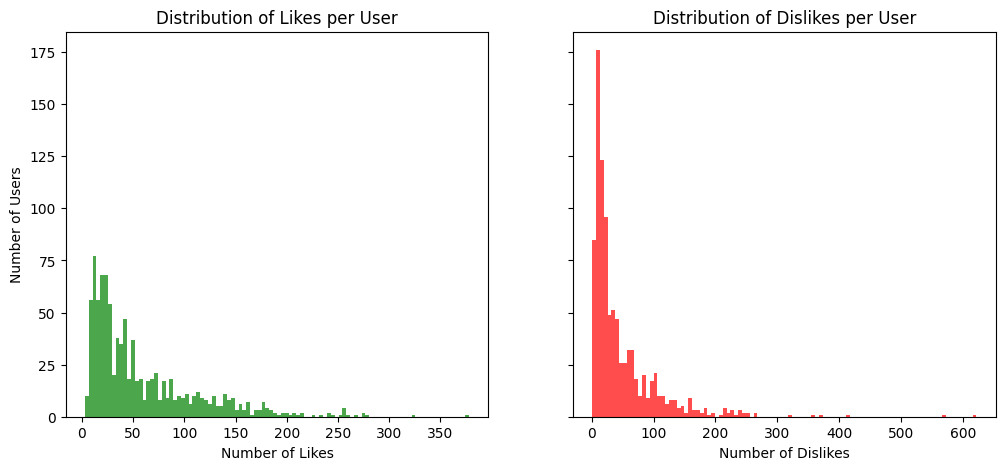

In [ ]:
grouped_data = load_data(os.path.join(DATA_DIR, 'u.data')).groupby(['userId', 'like']).count()

# Create separate DataFrames for likes and dislikes
likes_df = grouped_data.loc[pd.IndexSlice[:, 1], :].reset_index(level=1, drop=True)
dislikes_df = grouped_data.loc[pd.IndexSlice[:, 0], :].reset_index(level=1, drop=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot likes histogram
axes[0].hist(likes_df['itemId'], bins=100, color='green', alpha=0.7)
axes[0].set_title('Distribution of Likes per User')
axes[0].set_xlabel('Number of Likes')
axes[0].set_ylabel('Number of Users')

# Plot dislikes histogram
axes[1].hist(dislikes_df['itemId'], bins=100, color='red', alpha=0.7)
axes[1].set_title('Distribution of Dislikes per User')
axes[1].set_xlabel('Number of Dislikes')

# Display the plot
plt.show()

In [ ]:
load_data(os.path.join(DATA_DIR, 'ua.base')).groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,40664,40664,40664,40664
1,49906,49906,49906,49906


In [ ]:
load_data(os.path.join(DATA_DIR, 'ua.test')).groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,3961,3961,3961,3961
1,5469,5469,5469,5469


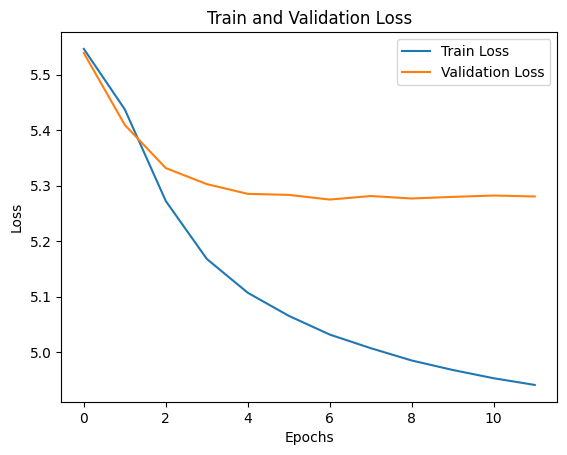

In [16]:
import matplotlib.pyplot as plt

train_losses, val_losses= model.get_metrics()
epochs = range(len(train_losses))

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


In [17]:
test_dataset = MovieDatasetWithFeatures(merged_df_test, device)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()
test_loss = []
for batch in test_dataloader:
    user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like = batch
    loss, similarity_matrix, user_feats, movie_feats = model(user_input, age_input, gender_input, profession_input, movie_input, genre_feats, like)
    print(f"test loss {loss:.4f}")
    test_loss.append(loss.item())

print(f"overall average test loss {np.mean(test_loss):.4f}")

test loss 3.2942
test loss 3.3854
test loss 3.4729
test loss 3.4579
test loss 3.1058
test loss 3.2617
test loss 3.2221
test loss 3.4587
test loss 3.0658
test loss 3.2746
test loss 3.4496
test loss 2.8928
test loss 2.9945
test loss 3.5155
test loss 3.2920
test loss 3.1628
test loss 3.5624
test loss 3.5180
test loss 3.1563
test loss 3.2409
test loss 3.4163
test loss 3.2046
test loss 3.4609
test loss 2.9948
test loss 3.3434
test loss 3.5373
test loss 3.2579
test loss 3.0913
test loss 3.0243
test loss 3.3227
test loss 3.3057
test loss 3.0274
test loss 3.0718
test loss 3.0258
test loss 3.3212
test loss 3.2464
test loss 3.3364
test loss 3.4072
test loss 3.3807
test loss 3.1760
test loss 3.1029
test loss 3.1877
test loss 3.2890
test loss 3.1499
test loss 3.2542
test loss 3.3061
test loss 2.9508
test loss 3.2793
test loss 2.9226
test loss 3.1670
test loss 3.3145
test loss 3.1724
test loss 3.0096
test loss 3.3653
test loss 3.1414
test loss 3.2794
test loss 3.0195
test loss 3.2272
test loss 3.39

In [18]:
user_feats.shape

torch.Size([22, 128])

In [19]:
movie_feats.shape

torch.Size([22, 128])

In [20]:
similarity_matrix.shape

torch.Size([22, 22])

<Axes: >

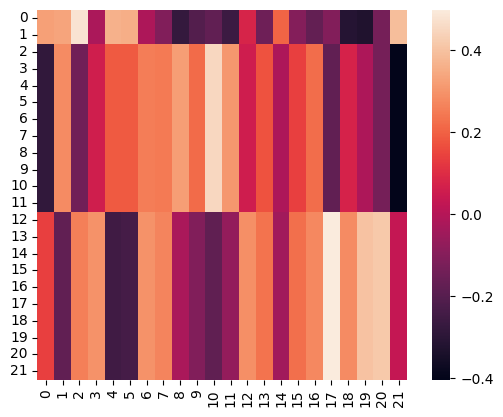

In [21]:
sns.heatmap(similarity_matrix.detach().numpy(), square=True)

In [ ]:
df_user.head()

,userId,gender,profession,age_group
0,1,1,19,2
1,2,0,13,9
2,3,1,20,2
3,4,1,19,2
4,5,0,13,4


In [ ]:
merged_df[merged_df['userId']==27].groupby('like').count()

,userId,itemId,rating,timestamp,gender,profession,age_group,unknown,action,adventure,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
like,,,,,,,,,,,,,,,,,,,,,
0,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

In [23]:
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
movie_embeddings = model.movie_tower(torch.tensor(df_item['itemId'].values, dtype=torch.long), torch.tensor(df_item.drop(columns=['itemId']).values, dtype=torch.float))
embs = tsne.fit_transform(movie_embeddings.detach().numpy())
df_item['x'] = embs[:, 0]
df_item['y'] = embs[:, 1]



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [29]:
df_item2 = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), delimiter='|', header=None, encoding='latin-1')
df_item2.columns = [
    'itemId', 'title', 'releaseDate', 'videoReleaseDate', 'imdbUrl', 'unknown', 'action', 'adventure', 'animation',
    'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror', 'musical', 'mystery', 'romance',
    'sciFi', 'thriller', 'war', 'western'
]
df_item2.drop(columns=['unknown', 'action', 'adventure', 'animation',
    'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror', 'musical', 'mystery', 'romance',
    'sciFi', 'thriller', 'war', 'western'], inplace=True)

In [30]:
full_df_item = df_item.merge(df_item2, on='itemId')

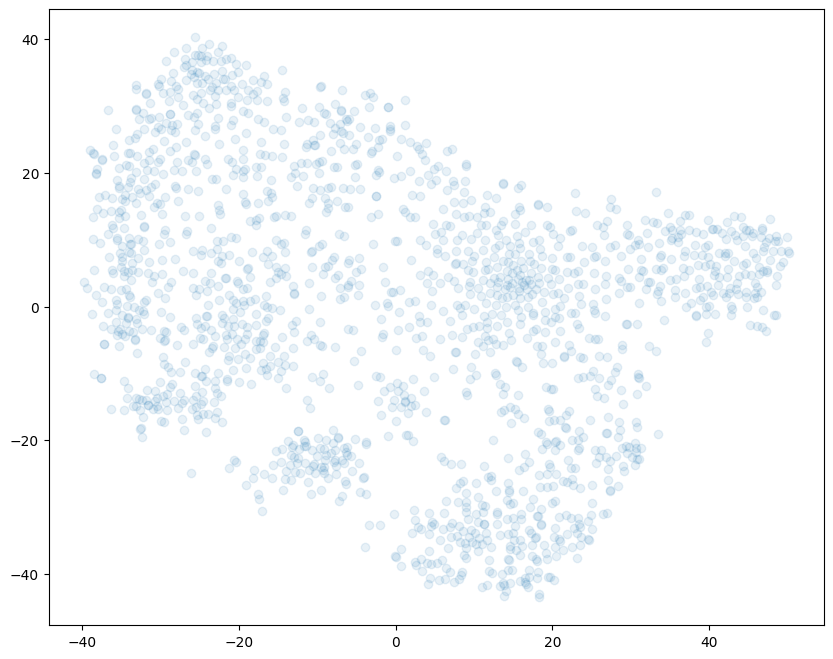

In [31]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(full_df_item.x, full_df_item.y, alpha=.1);

In [32]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(df, n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = df[df.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(df, sample.index)

def plot_by_title_pattern(df, pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(df, match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(df, label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')

    if text:
        # TODO: Add abbreviated title column
        titles = df.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts,
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(df, x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(df, title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    print(match)
    row = match.iloc[0]
    return plot_region(df, row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

<Axes: >

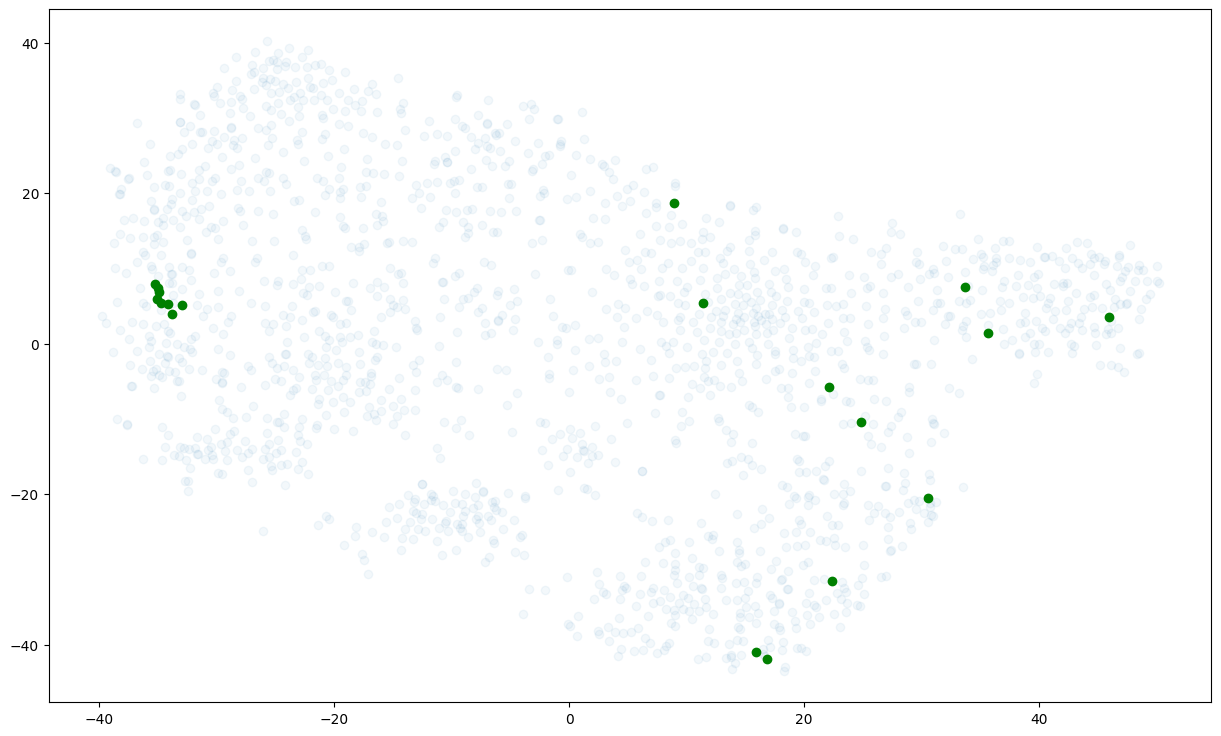

In [33]:
plot_by_title_pattern(full_df_item, 'Star', figsize=(15, 9), bg_alpha=.05, text=False)

In [35]:

!pip install fuzzywuzzy
from fuzzywuzzy import process


def movie_finder(title, df):
  all_titles = df['title'].tolist()
  closest_match = process.extractOne(title, all_titles)
  return closest_match

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [36]:
full_df_item[full_df_item.title == movie_finder('Star', full_df_item)[0]]

,itemId,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,...,sciFi,thriller,war,western,x,y,title,releaseDate,videoReleaseDate,imdbUrl
49,50,0,1,1,0,0,0,0,0,0,...,1,0,1,0,16.852907,-41.927761,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...


In [37]:
movie_finder('Star', full_df_item)

('Star Wars (1977)', 90)

Lion King, The (1994)
    itemId  unknown  action  adventure  animation  children  comedy  crime  \
70      71        0       0          0          1         1       0      0   

    documentary  drama  ...  sciFi  thriller  war  western          x  \
70            0      0  ...      0         0    0        0 -34.112301   

            y                  title  releaseDate  videoReleaseDate  \
70 -12.189692  Lion King, The (1994)  01-Jan-1994               NaN   

                                              imdbUrl  
70  http://us.imdb.com/M/title-exact?Lion%20King,%...  

[1 rows x 26 columns]


<Axes: >

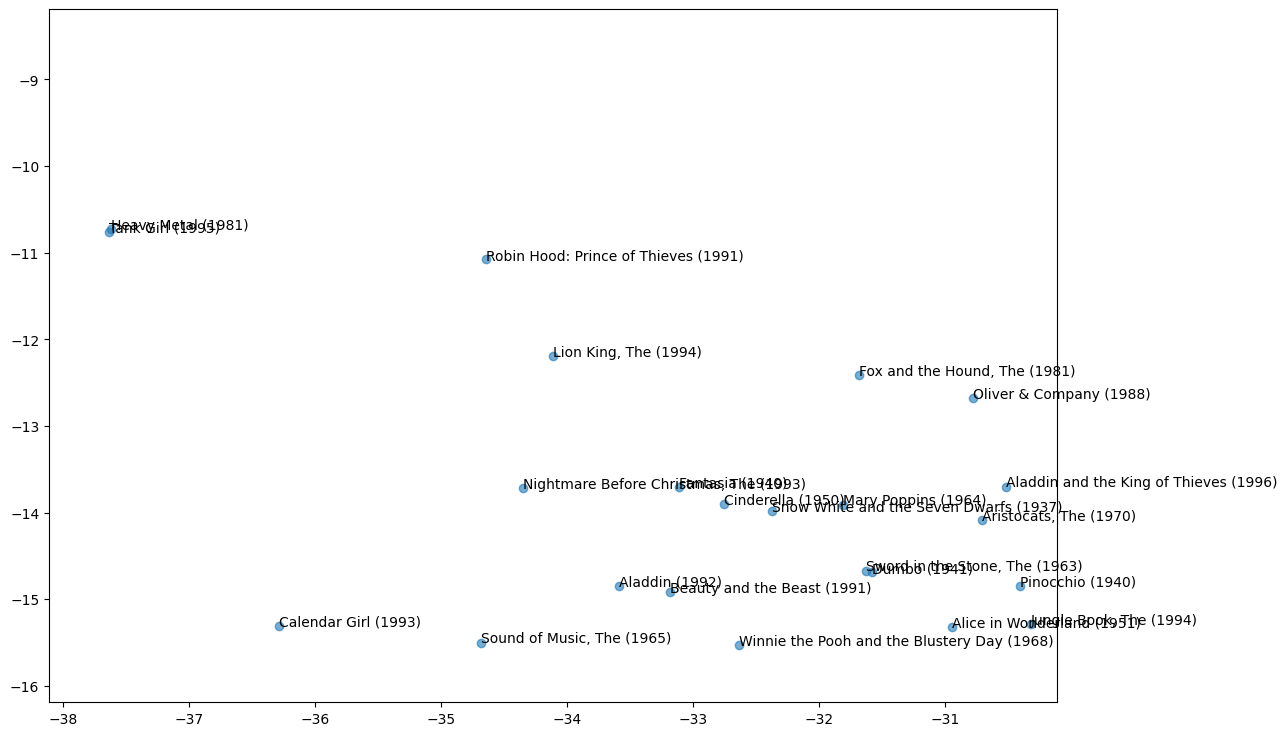

In [44]:
title = movie_finder('Lion King', full_df_item)[0]
print(title)
plot_region_around(full_df_item, title, 4)

Text(0.5, 1.0, 'Comedy Clusters')

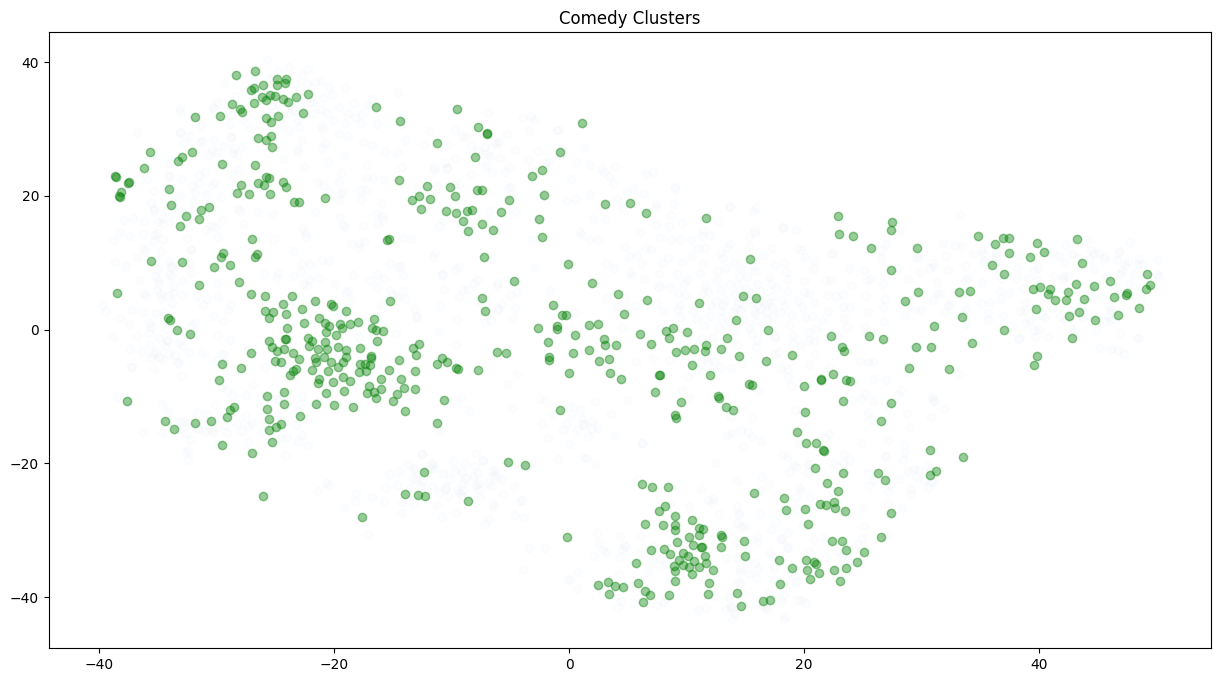

In [39]:
docs = full_df_item[ (full_df_item.comedy == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Comedy Clusters')

Text(0.5, 1.0, 'Children Clusters')

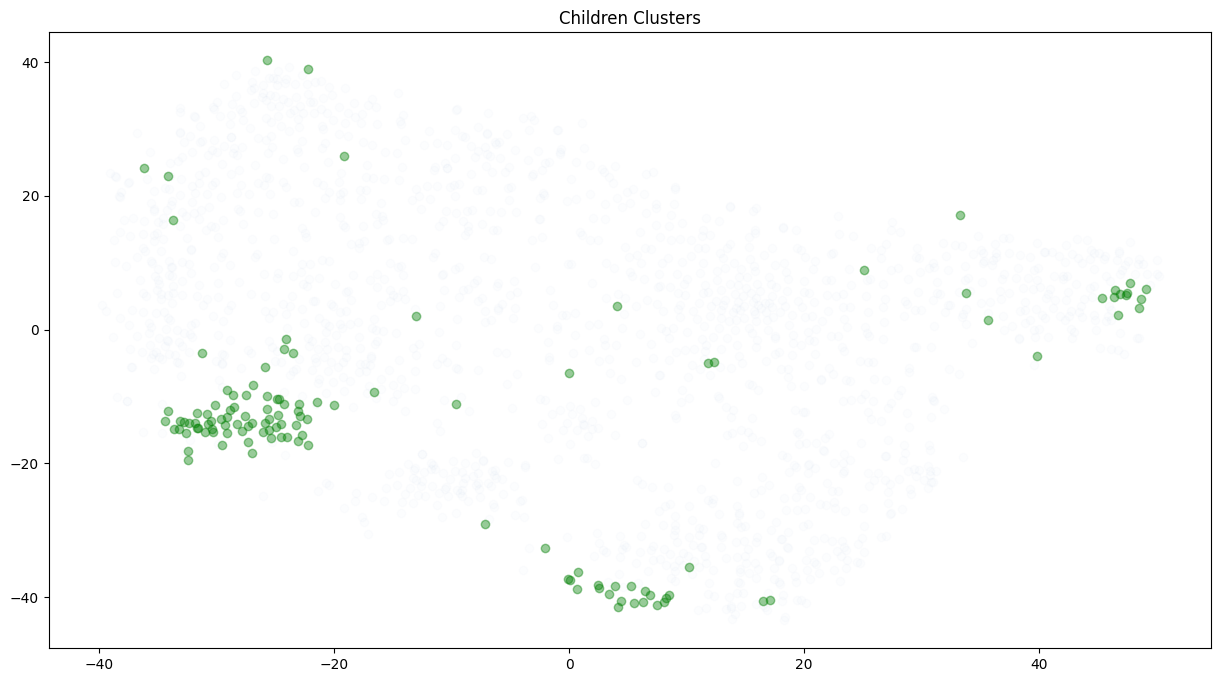

In [40]:
docs = full_df_item[ (full_df_item.children == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Children Clusters')

Text(0.5, 1.0, 'Romance Clusters')

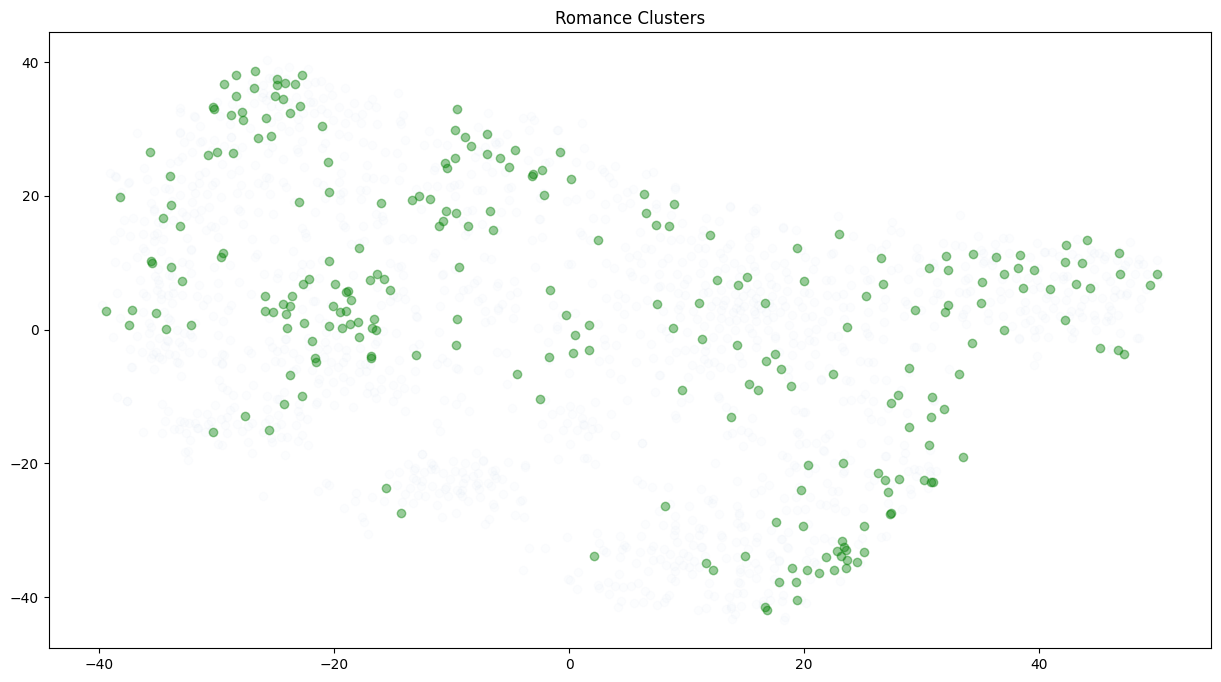

In [41]:
docs = full_df_item[ (full_df_item.romance == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Romance Clusters')

Text(0.5, 1.0, 'SciFi Clusters')

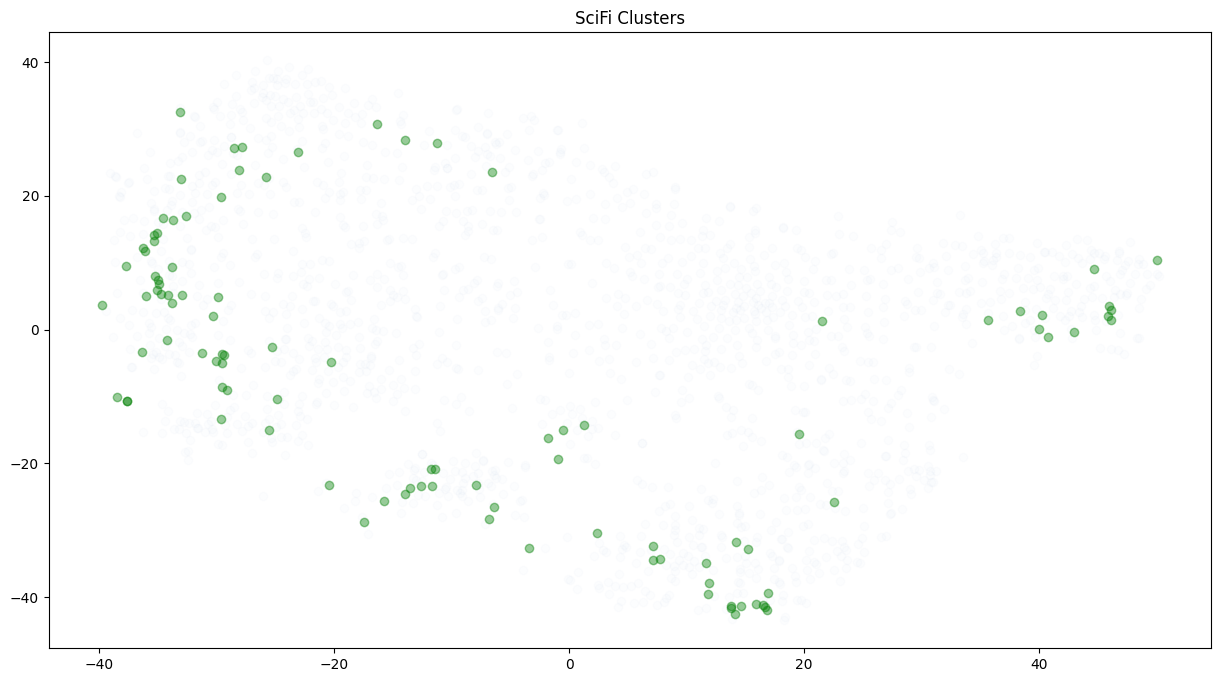

In [42]:
docs = full_df_item[ (full_df_item.sciFi == 1) ]
plot_with_annotations(full_df_item, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('SciFi Clusters')

In [48]:
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
user_embeddings = model.user_tower(torch.tensor(df_user['userId'], dtype=torch.long).to(device),
                                     torch.tensor(df_user['age_group'], dtype=torch.long).to(device),
                                     torch.tensor(df_user['gender'], dtype=torch.long).to(device),
                                     torch.tensor(df_user['profession'], dtype=torch.long).to(device))



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ValueError: Length of values (1682) does not match length of index (943)

In [49]:
embs = tsne.fit_transform(user_embeddings.detach().numpy())
df_user['x'] = embs[:, 0]
df_user['y'] = embs[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


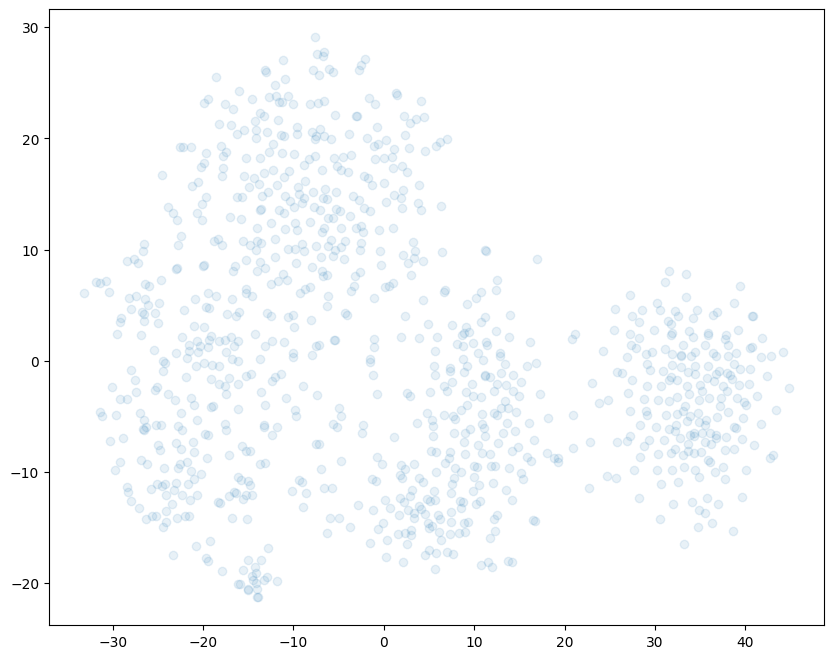

In [50]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df_user.x, df_user.y, alpha=.1)

Text(0.5, 1.0, 'Age Group 20-25')

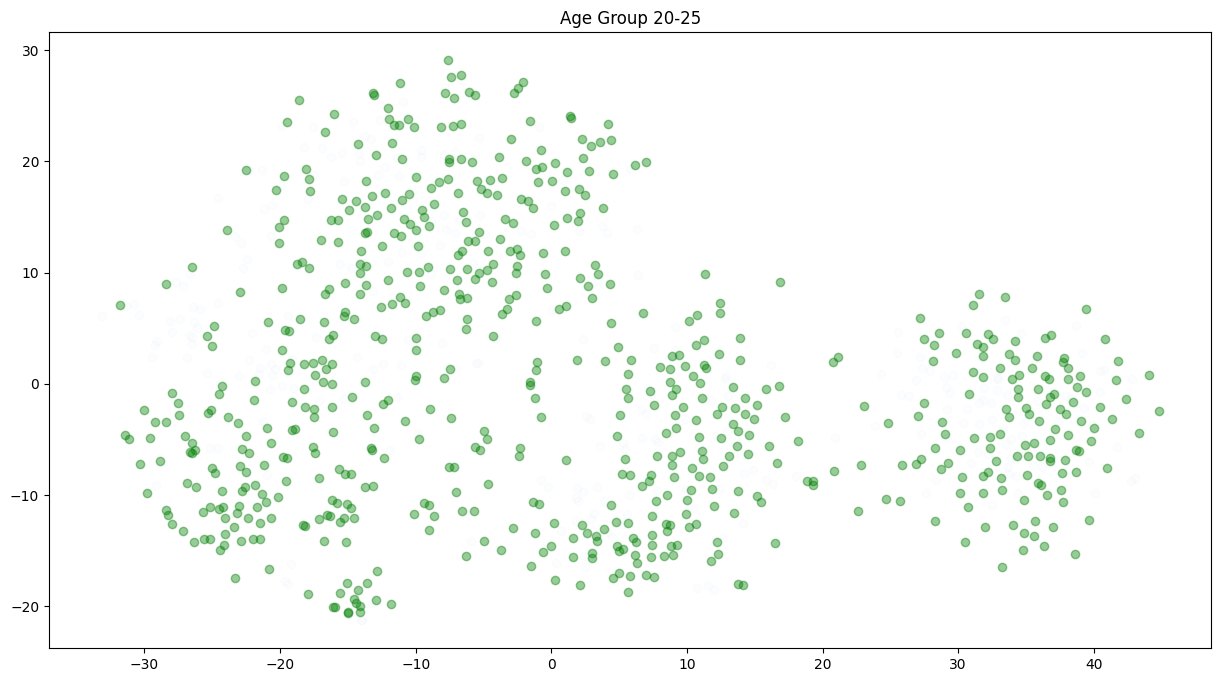

In [69]:
docs = df_user[ (df_user.gender == 1) ]
plot_with_annotations(df_user, docs.index, text=False, alpha=.4, figsize=(15, 8));
plt.title('Age Group 20-25')

In [67]:
le_gender.inverse_transform([0])

array(['F'], dtype=object)

In [63]:
df_user

,userId,gender,profession,age_group,x,y
0,1,1,19,2,-20.701006,-5.319801
1,2,0,13,9,6.994538,-2.760030
2,3,1,20,2,40.437958,-2.116040
3,4,1,19,2,40.856258,4.038387
4,5,0,13,4,-20.698507,1.776551
...,...,...,...,...,...,...
938,939,0,18,3,2.943630,-12.191275
939,940,1,0,4,1.020343,11.913427
940,941,1,18,2,10.654618,-12.651905
941,942,0,10,7,-8.221417,12.491845


In [162]:
df_data_train[df_data_train['userId']==13].groupby('like').count()

,userId,itemId,rating,timestamp
like,,,,
0,363,363,363,363
1,263,263,263,263


In [155]:
curr_df = df_user[df_user['userId']==10]
user_embeddings = model.user_tower(torch.tensor(curr_df['userId'].values, dtype=torch.long).to(device),
                                     torch.tensor(curr_df['age_group'].values, dtype=torch.long).to(device),
                                     torch.tensor(curr_df['gender'].values, dtype=torch.long).to(device),
                                     torch.tensor(curr_df['profession'].values, dtype=torch.long).to(device))
user_embeddings = user_embeddings.squeeze(0).detach().numpy()

In [156]:
curr_movie_df = df_item[df_item['itemId']==461]
movie_embeddings = model.movie_tower(torch.tensor(curr_movie_df['itemId'].values, dtype=torch.long),
                                     torch.tensor(curr_movie_df.drop(columns=['itemId', 'x', 'y']).values, dtype=torch.float))


In [157]:
movie_embeddings = movie_embeddings.squeeze(0).detach().numpy()
print(np.dot(user_embeddings, movie_embeddings))

0.29949415


,itemId,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,...,horror,musical,mystery,romance,sciFi,thriller,war,western,x,y
19,20,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,28.109411,-22.423807
